In [1]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split

import pandas as pd, mysql.connector, nltk
import xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from nltk.corpus import stopwords
import string
from collections import Counter

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preparation

In [4]:
# get the first file which has product titles and brand categoriws
df1 = pd.read_csv('\\Users\\Daniel\\Python\\Data\\Flix_products\\product_title.csv', engine='python')
df1.head(2)

,product_id,title,Categories
0,400002,HP Photosmart eStation Printer,Printers and Multifunction | Inkjet All-in-One...
1,400004,HP LaserJet Pro M1217nfw Multifunction Printer,Printers and Multifunction | Laser Multifuncti...


In [6]:
# load second product file and load only the necessary columns
products_complete = pd.read_csv('\\Users\\Daniel\\Python\\Data\\Flix_products\\products.csv', sep='\t')
products= products_complete[['product_id','product_title','mpn_list','manufacturer_id', 'brand_title',
                            'flix_parent_category', 'flix_subCategory1', 'flix_subCategory2',
                            'benchmark_category', 'benchmark_category2']]
products.head(2)

C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3044: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,product_id,product_title,mpn_list,manufacturer_id,brand_title,flix_parent_category,flix_subCategory1,flix_subCategory2,benchmark_category,benchmark_category2
0,3,Crematic Coffee Maker,F8744338,53.0,Groupe SEB,Small Gadgets/Appliances,Drink Makers,Coffee/Espresso,Home Appliances,Drink Makers
1,4,Vitamin Plus 3-Tier Steamer,vc400415,4.0,Tefal,Small Gadgets/Appliances,Cooking,Steamers,Home Appliances,Steamers


In [7]:
# merge the two products file with an inner join to keep only the common products from both
products = pd.merge(products, df1, on='product_id', how='inner')
products.head(2)

,product_id,product_title,mpn_list,manufacturer_id,brand_title,flix_parent_category,flix_subCategory1,flix_subCategory2,benchmark_category,benchmark_category2,title,Categories
0,881868,HP EliteBook 840 G1 Notebook PC,J8Q77EA,28.0,HP,Computing/Gaming,Laptops/Notebook/Ebook/Ultrabook,Notebooks,Computing,Laptops,HP EliteBook 840 G1 Notebook PC,Laptops And Hybrids | Business Laptop PCs | HP...
1,876236,Speedlight SB-N7,FSA90901,1290.0,Nikon,Cameras,Camera Accessories,None,Cameras,Cameras Accessories,Speedlight SB-N7,Speedlights


In [8]:
# check how many products have unassigned categories
products['benchmark_category2'].isna().sum(), products['benchmark_category2'].isna().sum()/len(products.index)

(1680, 0.023105805333590065)

In [9]:
# drop the unassugned category products
products.dropna(subset=['benchmark_category2'], inplace=True)

Text(0.5, 0, '# of products')

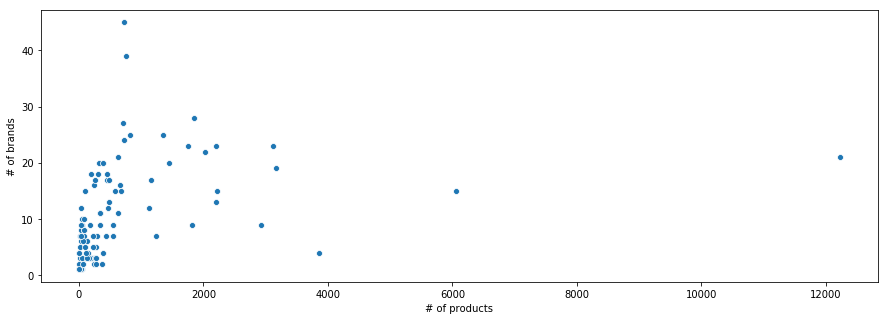

In [10]:
# let's look at the distribution of number of products and brands by product categories
group_products = products.groupby('benchmark_category2')['product_id'].count()
group_brand  = products.groupby('benchmark_category2')['brand_title'].nunique()
plt.figure(figsize=(15,5))
ax = sns.scatterplot(x=group_products, y=group_brand)
ax.set_ylabel('# of brands')
ax.set_xlabel('# of products')

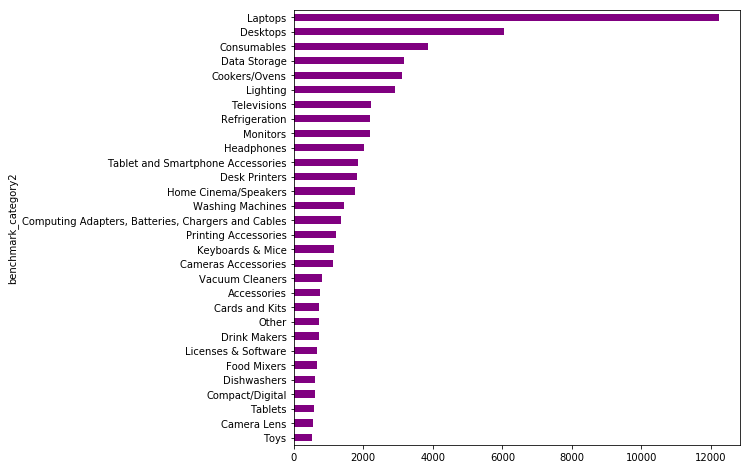

In [11]:
# lets look at the top 30 categories by number of products
products.groupby('benchmark_category2')['product_id'].count().sort_values().tail(30).plot.barh(figsize=(8,8), color='purple')

In [12]:
# lets subset by top 15 categories and use this data for further analysis
top15cats = products.groupby('benchmark_category2')['product_id'].count().nlargest(15).keys()
prod_15cats = products[products['benchmark_category2'].isin(top15cats)].reset_index()
prod_15cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48227 entries, 0 to 48226
Data columns (total 13 columns):
index                   48227 non-null int64
product_id              48227 non-null int64
product_title           47698 non-null object
mpn_list                47976 non-null object
manufacturer_id         48227 non-null float64
brand_title             48227 non-null object
flix_parent_category    48227 non-null object
flix_subCategory1       48227 non-null object
flix_subCategory2       40661 non-null object
benchmark_category      48227 non-null object
benchmark_category2     48227 non-null object
title                   48227 non-null object
Categories              48227 non-null object
dtypes: float64(1), int64(2), object(10)
memory usage: 4.8+ MB


# 2. Categorisation with product titles and categories

In [13]:
prod_15cats['Categories'].head(2)

0    Laptops And Hybrids | Business Laptop PCs | HP...
1                   Electrolux | NonStar | Cooker_Hood
Name: Categories, dtype: object

In [14]:
# Remove the pipes '|' in the Categories
prod_15cats['Categories'] = prod_15cats['Categories'].str.replace('|', '')
prod_15cats['Categories'].head(2)

0    Laptops And Hybrids  Business Laptop PCs  HP E...
1                     Electrolux  NonStar  Cooker_Hood
Name: Categories, dtype: object

In [15]:
# lets concatenate the two columns : product titles and categories
prod_15cats['title&cat']=np.nan
for i in range(len(prod_15cats)):
    if pd.isna(prod_15cats.loc[i, 'product_title']):
        prod_15cats.loc[i, 'title&cat'] =  prod_15cats.loc[i, 'title'] + ' ' + prod_15cats.loc[i, 'Categories']
    else:
        prod_15cats.loc[i,'title&cat'] =  prod_15cats.loc[i, 'product_title'] + ' ' + prod_15cats.loc[i, 'Categories']

In [20]:
prod_15cats.to_csv('prod_15cats.csv', sep='\t', encoding='utf-8', index=False)

In [114]:
prod_15cats = pd.read_csv('prod_15cats.csv', sep='\t')

In [162]:
# check for empty strings in the two columns 
#prod_15cats[prod_15cats[['product_title','Categories']].isnull().values.any(1)]

# Bags of Word model

In [47]:
# functions to tokenize the whole doc and form a vocabulary

# clean texts
def tokenize_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [w.lower() for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load text and add to vocab
def add_to_vocab(column, vocab):
    for i in range(len(column)):
        tokens = tokenize_doc(column[i])
        vocab.update(tokens)  

In [48]:
#create the vocabulary after tokenization of the whole doc
vocab = Counter()
add_to_vocab(prod_15cats['title&cat'], vocab)

In [49]:
# length of the vocab and the most occuring words
len(vocab), print(vocab.most_common(20))
#print(vocab.most_common()[:len(vocab)-100:-1])  # to obtain the lower list

[('hp', 71418), ('pc', 35804), ('notebook', 25007), ('series', 18939), ('pavilion', 12386), ('desktop', 10149), ('pcs', 10050), ('home', 9417), ('workstation', 8230), ('compaq', 7380), ('mobile', 6067), ('ink', 5920), ('elitebook', 5737), ('probook', 5642), ('led', 5609), ('philips', 5544), ('tv', 5533), ('printer', 4692), ('cartridges', 4653), ('consumer', 4535)]


(6615, None)

In [50]:
# remove tokens with just one occurence to reduce the vocab size
tokens = [k for k,c in vocab.items() if c > 1]
print('Vocabulary size: {}'.format( len(tokens)))

Vocabulary size: 4378


In [51]:
# save the vocabulary to a file
def save_vocab(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w', encoding="utf-8")
    file.write(data)
    file.close()
    
# save the vocabulary
save_vocab(tokens, 'vocab.txt')

In [65]:
# function to tokenize each row
def tokenize_row(column, vocab):
    tokenz = []
    for i in range(len(column)):
        tokens = tokenize_doc(column[i])
        tokens = [w for w in tokens if w in vocab]
        tokenz.append(tokens)
    return tokenz

In [115]:
# tokenize each row
prod_15cats['tokens'] = tokenize_row(prod_15cats['title&cat'], vocab)
prod_15cats['tokens'].head()

0    [hp, elitebook, notebook, pc, laptops, hybrids...
1    [electrolux, chimney, design, hood, cm, db, el...
2    [electrolux, chimney, design, hood, cm, db, el...
3                    [oven, electrolux, nonstar, oven]
4    [backup, plus, desk, für, den, mac, mit, thund...
Name: tokens, dtype: object

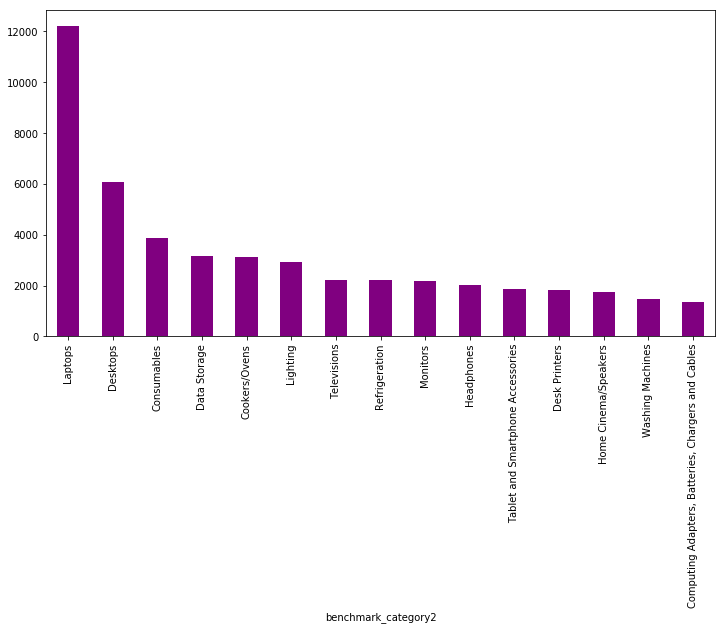

In [54]:
# lets look at the top 30 categories by number of products
prod_15cats.groupby('benchmark_category2')['product_id'].count().nlargest(15).plot.bar(figsize=(12,6), color='purple')

In [116]:
# create train and test set with stratified sampling
y = prod_15cats.pop('benchmark_category2')
x = prod_15cats['tokens']
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=42, stratify=y)

# TF-IDF Vectors as features

In [119]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [128]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words='english')
tfidf_vect.fit(prod_15cats['tokens'].map(str))
x_train_tfidf =  tfidf_vect.transform(x_train)
x_test_tfidf =  tfidf_vect.transform(x_test)

AttributeError: 'list' object has no attribute 'lower'

In [97]:
x_train_tfidf[1,:150].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]])

In [101]:
len(set(tfidf_vect.vocabulary_))

6568

In [127]:
prod_15cats['tokens']

0        [hp, elitebook, notebook, pc, laptops, hybrids...
1        [electrolux, chimney, design, hood, cm, db, el...
2        [electrolux, chimney, design, hood, cm, db, el...
3                        [oven, electrolux, nonstar, oven]
4        [backup, plus, desk, für, den, mac, mit, thund...
5        [gear, wrist, watch, strap, mobile, devices, a...
6        [gear, wrist, watch, strap, mobile, devices, a...
7                    [jbl, horizon, white, home, speakers]
8        [harman, kardon, esquire, mini, whitecurrent, ...
9        [tall, larder, led, display, fridges, refriger...
10       [frost, freezer, led, display, freezers, refri...
11       [washing, machine, energy, rating, steam, refr...
12       [washing, machine, spin, speed, washing, machi...
13                      [epson, workforce, pro, dn, epson]
14       [high, performance, category, utp, patch, cabl...
15       [microcharge, amp, chargesync, homesearch, inc...
16       [patch, cable, snagless, molded, homesearch, n.

In [105]:
prod_15cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48227 entries, 0 to 48226
Data columns (total 13 columns):
product_id              48227 non-null int64
product_title           47698 non-null object
mpn_list                47976 non-null object
manufacturer_id         48227 non-null float64
brand_title             48227 non-null object
flix_parent_category    48227 non-null object
flix_subCategory1       48227 non-null object
flix_subCategory2       40661 non-null object
benchmark_category      48227 non-null object
title                   48227 non-null object
Categories              48227 non-null object
title&cat               48227 non-null object
tokens                  48227 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 4.8+ MB
